<a href="https://www.kaggle.com/code/fotimakhongulomova/sign-language-digits-with-keras?scriptVersionId=160346302" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Sign Language Digits with Keras

## Notebook Imports

In [1]:
%%capture --no-display
!pip install tensorflow
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%capture --no-display

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


## Organizing data into Train, Valid, Test dirs

In [4]:
input_folder = '/kaggle/input/signlanguagedigitsdataset/Dataset'
output_folder = '/kaggle/working/dataset'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Function to copy either a file or a directory
def copy_item(item_name):
    source_path = os.path.join(input_folder, item_name)
    destination_path = os.path.join(output_folder, item_name)
    if os.path.isfile(source_path):
        shutil.copy(source_path, destination_path)
    elif os.path.isdir(source_path):
        shutil.copytree(source_path, destination_path)

# List all items in the input folder (files and directories)
items_list = os.listdir(input_folder)

# Copy each item from the input to the output folder
for item_name in items_list:
    copy_item(item_name)

# Check if items are successfully copied
output_items = os.listdir(output_folder)
print(f"Items successfully copied to output folder: {output_items}")

Items successfully copied to output folder: ['7', '1', '4', '8', '5', '0', '9', '6', '3', '2']


In [5]:
os.chdir('/kaggle/working/dataset')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        
        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
        
        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
            
os.chdir('../..')

In [6]:
for i in range(0, 10):
    assert len(os.listdir(f'/kaggle/working/dataset/valid/{i}')) == 30
    assert len(os.listdir(f'/kaggle/working/dataset/test/{i}')) == 5

In [7]:
train_path = '/kaggle/working/dataset/train'
valid_path = '/kaggle/working/dataset/valid'
test_path = '/kaggle/working/dataset/test'

In [8]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224, 224), batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224, 224), batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224, 224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [9]:
assert train_batches.n == 1712
assert valid_batches.n == 300
assert test_batches.n == 50
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10

## Modify Model

In [10]:
%%capture --no-display

mobile = tf.keras.applications.mobilenet.MobileNet()

In [11]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [12]:
x = mobile.layers[-6].output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = Dense(units=10, activation='softmax')(x)

In [13]:
model = Model(inputs=mobile.input, outputs=output)

In [14]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

## Train the Model

In [16]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Run for more epoch (~30) to see better results
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
172/172 - 11s - loss: 0.3861 - accuracy: 0.8768 - val_loss: 1.4562 - val_accuracy: 0.6100 - 11s/epoch - 65ms/step
Epoch 2/10
172/172 - 3s - loss: 0.0829 - accuracy: 0.9743 - val_loss: 0.2480 - val_accuracy: 0.9067 - 3s/epoch - 19ms/step
Epoch 3/10
172/172 - 3s - loss: 0.0353 - accuracy: 0.9889 - val_loss: 0.1029 - val_accuracy: 0.9733 - 3s/epoch - 20ms/step
Epoch 4/10
172/172 - 3s - loss: 0.0901 - accuracy: 0.9725 - val_loss: 0.1826 - val_accuracy: 0.9367 - 3s/epoch - 19ms/step
Epoch 5/10
172/172 - 3s - loss: 0.0335 - accuracy: 0.9895 - val_loss: 0.1232 - val_accuracy: 0.9533 - 3s/epoch - 19ms/step
Epoch 6/10
172/172 - 3s - loss: 0.0213 - accuracy: 0.9936 - val_loss: 0.1314 - val_accuracy: 0.9600 - 3s/epoch - 19ms/step
Epoch 7/10
172/172 - 3s - loss: 0.0334 - accuracy: 0.9883 - val_loss: 0.0557 - val_accuracy: 0.9800 - 3s/epoch - 19ms/step
Epoch 8/10
172/172 - 3s - loss: 0.0129 - accuracy: 0.9947 - val_loss: 0.0670 - val_accuracy: 0.9767 - 3s/epoch - 19ms/step
Epoch 9/10
172

## Predict sign language digits

In [18]:
test_labels = test_batches.classes
test_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9], dtype=int32)

In [19]:
predictions = model.predict(x=test_batches, verbose=0)

In [20]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [21]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

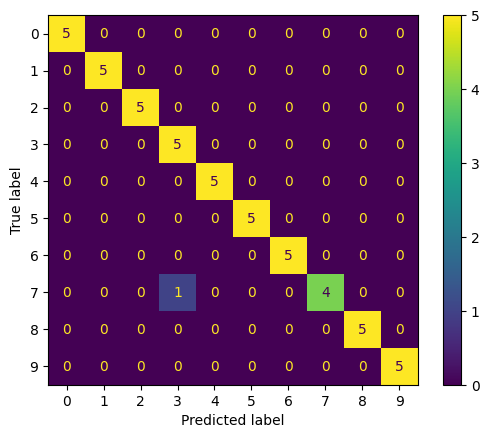

In [22]:
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
disp.plot()
plt.show()